In [129]:
from functools import reduce

import jax.numpy as jnp
from jax.random import PRNGKey, uniform
from jax.experimental import optimizers
from jax import grad

from qutip import sigmaz

import matplotlib.pyplot as plt

from qgrad.qgrad_qutip import basis, expect, Unitary

In [130]:
# Parametereized unitary not needed
'''
N = 4 # 2 qubit ciruit
num_params = N * (N - 1) // 2 
unitary = Unitary(4)

# PRNGKey for reproducible results
thetas = uniform(PRNGKey(0), (num_params, ), minval=0,
                maxval= 2 * jnp.pi)
phis = uniform(PRNGKey(1), (num_params, ), minval=0,
                maxval= 2 * jnp.pi)
omegas = uniform(PRNGKey(2), (N, ), minval=0,
                maxval= 2 * jnp.pi)
rand_unitary = unitary(thetas, phis, omegas)
'''

'\nN = 4 # 2 qubit ciruit\nnum_params = N * (N - 1) // 2 \nunitary = Unitary(4)\n\n# PRNGKey for reproducible results\nthetas = uniform(PRNGKey(0), (num_params, ), minval=0,\n                maxval= 2 * jnp.pi)\nphis = uniform(PRNGKey(1), (num_params, ), minval=0,\n                maxval= 2 * jnp.pi)\nomegas = uniform(PRNGKey(2), (N, ), minval=0,\n                maxval= 2 * jnp.pi)\nrand_unitary = unitary(thetas, phis, omegas)\n'

In [131]:
def rx(phi): 
    return jnp.array([[jnp.cos(phi / 2), -1j * jnp.sin(phi / 2)],
                     [-1j * jnp.sin(phi / 2), jnp.cos(phi / 2)]])

def ry(phi):
    return jnp.array([[jnp.cos(phi / 2), -jnp.sin(phi / 2)],
                     [jnp.sin(phi / 2), jnp.cos(phi / 2)]])


def rz(phi):
    return jnp.array([[jnp.exp(-1j * phi / 2), 0],
                     [0, jnp.exp(1j * phi / 2)]])

def cnot():
    return jnp.array([[1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 0, 1],
                     [0, 0, 1, 0]],)


In [132]:
def circuit(params):
    """Returns the state evolved by the parameterized circuit"""
    thetax, thetay, thetaz = params
    layer0 = jnp.kron(basis(2, 0), basis(2, 0))
    layer1 = jnp.kron(ry(jnp.pi / 4), ry(jnp.pi / 4))
    layer2 = jnp.kron(rx(thetax), jnp.eye(2))
    layer3 = jnp.kron(ry(thetay), rz(thetaz))
    layers = [layer1, cnot(), layer2, cnot(), layer3]
    unitary = reduce(lambda  x, y : jnp.dot(x, y), layers)
    return jnp.dot(unitary, layer0)

In [133]:
# Measure pauli Z on the first qubit
op = jnp.kron(jnp.array(sigmaz().full()), jnp.eye(2))

def cost(params, op):
    state = circuit(params)
    return jnp.real(expect(op, state))

In [134]:
init_params = [jnp.pi / 3., jnp.pi / 3., jnp.pi / 3.] # random initialization
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-2)
opt_state = opt_init(init_params)

def step(i, opt_state, opt_update):
    params = get_params(opt_state)
    g = grad(cost)(params, op)
    return opt_update(i, g, opt_state)

epochs = 400
loss_hist = []

for epoch in range(epochs):
    opt_state = step(epoch, opt_state, opt_update)
    params = get_params(opt_state)
    loss = cost(params, op)
    loss_hist.append(loss)
    progress = [epoch+1, loss]
    if (epoch % 100 == 99):
        print("Epoch: {:2f} | Loss: {:3f}".format(*jnp.asarray(progress)))

Epoch: 100.000000 | Loss: -0.707132
Epoch: 200.000000 | Loss: -0.713067
Epoch: 300.000000 | Loss: -0.985571
Epoch: 400.000000 | Loss: -1.000000


Text(0.5, 0, 'epochs')

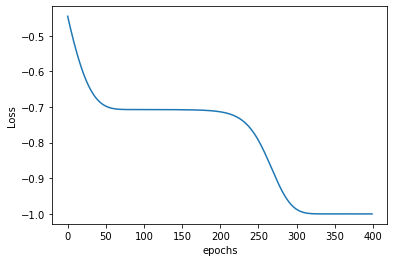

In [135]:
plt.plot(loss_hist)
plt.ylabel("Loss")
plt.xlabel("epochs")